# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

C:\Users\silim\AppData\Local\Temp\ipykernel_3388\3012595547.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  all_geoms = gdf.unary_union


Оберіть область для якої знайти центральну точку від 1 до $10 1
Оберіть область для якої знайти центральну точку від 1 до $10 4


Центральна точка області 1: POINT (22.169082089352933 49.9536852378464)
Центральна точка області 2: POINT (16.410691396816098 51.089506983828386)
Відстань між облястю 1 і областю 2: 427.33 км


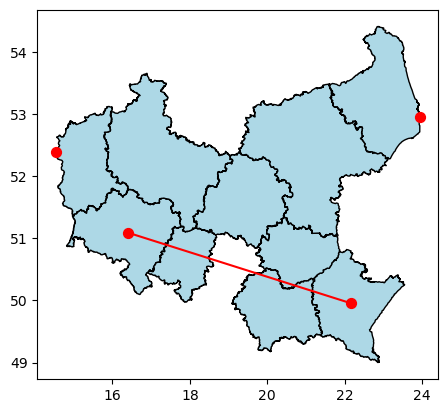

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoSeries
from pyproj import Geod
from shapely import Point, LineString, Polygon, MultiPolygon

gdf = gpd.read_file("./poland_Provinces_level_1/poland_Provinces_level_1.shp")
ax = gdf.plot(color='lightblue', edgecolor='black')



all_geoms = gdf.unary_union

if isinstance(all_geoms, Polygon):
    coords = list(all_geoms.exterior.coords)
elif isinstance(all_geoms, MultiPolygon):
    coords = []
    for poly in all_geoms.geoms:
        coords.extend(list(poly.exterior.coords))

west_point = min(coords, key=lambda x: x[0])
east_point = max(coords, key=lambda x: x[0])


area = int(input(f"Оберіть область для якої знайти центральну точку від 1 до ${len(gdf)}"))
obj1 = gdf.iloc[area-1]
centroid = obj1.geometry.centroid


area2 = int(input(f"Оберіть область для якої знайти центральну точку від 1 до ${len(gdf)}"))
obj2 = gdf.iloc[area2-1]
centroid2 = obj2.geometry.centroid

geod = Geod(ellps="WGS84")
distance = geod.inv(centroid.x, centroid.y, centroid2.x, centroid2.y)[2] / 1000  # в кілометрах
print("Центральна точка області 1:", centroid)
print("Центральна точка області 2:", centroid2)
print(f"Відстань між облястю 1 і областю 2: {distance:.2f} км")


# Побудувати мапу
line = LineString([centroid, centroid2])
centroid_gdf = gpd.GeoDataFrame(geometry=[centroid, centroid2, Point(west_point), Point(east_point), line], crs=gdf.crs)
centroid_gdf.plot(ax=ax, color='red', markersize=50)

plt.show()

In [ ]:
5